# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [17]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math

from observation_model import get_nnet

from multiprocessing import Pool, Process
# from multiprocessing.pool import ThreadPool
# import threading

import importlib
import fst_graph
from fst_graph import *
importlib.reload(fst_graph)

# %run language_model.ipynb

<module 'fst_graph' from '/afs/inf.ed.ac.uk/user/s26/s2653879/Documents/ASR/asr_assignment/fst_graph.py'>

In [18]:
def add_to_file(file: str, txt: str):
    f = open(file, 'a')
    f.write(txt)
    f.close()

In [19]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is not really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name, nnet, loaded_first_rec):
        """Set up the decoder class with an audio file and WFST f
        """
        self.pruning_limit_const = 40 # 40
        self.om = observation_model.ObservationModel(nnet, loaded_first_rec)
        self.f = f
        
        self.cache_prob = {}
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
        
    def get_om_prob(self, phone_state: str, t: int):
        key = f'{phone_state} {t}'
        if key in self.cache_prob:
            return self.cache_prob[key]
        
        value = self.om.log_observation_probability(phone_state, t)
        self.cache_prob[key] = value
        return value
    
    def pruning_limit(self, t):
#         return NLL_ZERO
        return self.current_best[t] + self.pruning_limit_const
    
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []
        self.B = [] # B[t][i]
        self.W = []
        
        self.current_best = []
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append(['']*self.f.num_states())
            
            self.current_best.append(NLL_ZERO)
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        start_state = self.f.start()
        N = len(lex)
        for arc in self.f.arcs(start_state):
            s = arc.nextstate
            self.V[0][s] = -math.log(1/N)

        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """

        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            olbl = arc.olabel
                            olbl = self.f.output_symbols().find(olbl)
                            self.W[t][j] = self.W[t][i] + " " + olbl
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        for i in self.f.states():
            
#             if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
            if not self.V[t-1][i] >= self.pruning_limit(t):
            
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.get_om_prob(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
#                         print(tp, ep, self.V[t-1][i])
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                    
                            if prob < self.current_best[t]:
                                self.current_best[t] = prob
                            
                            # store the output labels encountered too
                            olbl = arc.olabel
                            olbl = self.f.output_symbols().find(olbl)
                            self.W[t][j] = olbl
#             else:
#                 print("pruned", self.V[t-1][i], self.pruning_limit(t))
    
    def finalise_decoding(self):
        
        # TODO - exercise
        states = list(range(self.f.num_states()))
        for i in states:
            prob_final = float(self.f.final(i)) # probablity of being the end state (0 for non finals, and upwards of 1 if one final state, or split between all final states)
            if (self.V[-1][i] < self.NLL_ZERO):
                if (prob_final == math.inf): # not a final state
                    self.V[-1][i] = self.NLL_ZERO
                else: # is a final state
                    self.V[-1][i] += prob_final # includes the weighting of ending at each of the final states in the path towards them in the last step
        
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.traverse_epsilon_arcs(t)
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        
        self.finalise_decoding()
    
    def backtrace(self):
        T = self.om.observation_length()
        current = -1
        for i in range(self.f.num_states()):
            if (float(self.f.final(i)) != math.inf): # if i is final
                if (self.B[T][i] != -1):
                    if (current == -1):
                        current = i
                    elif (self.V[-1][current] > self.V[-1][i]):
                        current = i
        if (current == -1):
            raise Exception('No valid path')
        seq = [current]
        currentStr = ''
        strSeq = ''
        
        for t in range(T,-1, -1):
            tmp_str = self.W[t][current].split(" ")
            for tmpStr in tmp_str:
                if not(tmpStr in ['', '<eps>']):
                    currentStr = tmpStr
                    strSeq = f'{currentStr} {strSeq}'


                current = self.B[t][current]
                seq.insert(0, current)
        
        
        strSeq = strSeq.strip()
        best_state_sequence = (seq, strSeq)
        
        return best_state_sequence

In [20]:
class ResultsPrinter:
    def __init__(self, useFile=True):
        self.count = 0
        self.useFile = useFile
        
        if self.useFile:
            with open("results_printer_counter.txt", "w") as f:
                f.write("0")
                
    def clear(self):
        self.count = 0
        self.set_counter(0)
        
    def get_counter(self) -> int:
        if not self.useFile:
            return self.count
        
        counter = self.count
        try:
            with open("restult_printer_counter.txt", "r") as f:
                counter = int(f.read())
        except:
            pass

        return counter
    
    def set_counter(self, new_val: int):
        if not self.useFile:
            self.count = new_val
            return
        
        with open("restult_printer_counter.txt", "w") as f:
            f.write(str(new_val))
    
    def increment_counter(self):
        if not self.useFile:
            self.count += 1
            return
        
        c = self.get_counter()
        self.set_counter(c + 1)
    
    def print(self, txt):
        count = self.get_counter()
        print(f"{count}:\n{txt}")
        
        self.increment_counter()
    
resP = ResultsPrinter()

In [21]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

# def proc_run(inputArgs):
#     files, f, start, isPrint = inputArgs

class bool_atr:
    def __init__(self, data):
        self.data = data
    def get_data(self):
        return self.data
    def set_data(self, new_data):
        self.data = new_data

def proc_run(files, f, start=0, isPrint=False):
    res_results = ""
    res_wer = ""
    counter = start
    
    nnet = get_nnet()
    loaded_first_rec = bool_atr(False)
    for wav_file in files:
        decoder = MyViterbiDecoder(f, wav_file, nnet, loaded_first_rec)
        
        decoder.decode()
#         print(decoder.V)
#         input()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path


        transcription = read_transcription(wav_file)
        text = (f"\n\n[{wav_file}]\n\n{state_path}\n\n[{words}]\n[{transcription}]")
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        res = f'{error_counts} {word_count}\n'     # you'll need to accumulate these to produce an overall Word Error Rate
        
        txt = f'{counter}\n{words}\n{transcription}\n{res}'
        if isPrint:
            print(txt)
        else:
            resP.print(txt)

        add_to_file('results.txt', f'{text}\n{res}')
        res_results += f"{text}\n{res}"
        add_to_file('wer_data.txt', res)
        res_wer += res
        
        counter += 1

    del(nnet)
    return res_results, res_wer

def run(is_copy=True):
    f = create_wfst()
    resP.clear()
    
    files = list(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))
    
    if (is_copy):
        # copy to prev
        with open('results_prev.txt', 'w') as file:
            with open('results.txt', 'r') as file2:
                file.write(file2.read())
        with open('wer_data_prev.txt', 'w') as file:
            with open('wer_data.txt', 'r') as file2:
                file.write(file2.read())
    
    # clear results file
    with open('results.txt', 'w') as file:
        pass
    # clear results file
    with open('wer_data.txt', 'w') as file:
        pass
#     minis = [
#         files[11],
#         files[132],
#         files[6],
#         files[318],
#         files[10]
#     ]
#     mids = [
#         files[9],
#         files[109],
#         files[153],
#         files[182],
#         files[206]
#     ]

#     proc_run(files, f, 0, True)

    # multiprocessing    
    thread_size = 20
    proc_run_args = []
    for i in range(0, len(files)-thread_size, thread_size):
        start = i
        end = i+thread_size
        end = end if end <= len(files) else len(files)
        proc_run_args.append((files[start:end], f, start, False))
    
    with Pool() as p:
        p.starmap(proc_run, proc_run_args)
    
    #multithreading
#     with ThreadPool() as ts:
#         ts.starmap(proc_run, proc_run_args)

In [22]:
%%timeit -r 1 -n 1
# run(True)
if __name__ == "__main__":
    run(False)

0:
120
a peck pickled peter
peck pickled peter
(0, 0, 1) 3

1:
60
a peck piper peter of pickled peck
peck piper peter pickled picked
(1, 0, 2) 5

2:
140
a of of pickled picked picked
peter piper picked a peck of pickled peppers
(2, 3, 1) 8

3:
40
a peck peter picked picked pickled peppers peter
piper peter picked where's the pickled peppers peter
(2, 1, 1) 8

4:
220
a peck of peck of pickled peter peter piper picked
where's the peck of pickled peppers peter piper picked
(3, 0, 1) 9
4:
180
a peter peter picked of peck of pickled peppers
peter piper picked a peck of pickled peppers
(2, 0, 1) 8


6:
160
a peter piper of picked of peck of pickled piper peppers
peter piper picked a peck of pickled peppers
(1, 0, 3) 8

7:
80
a picked picked peck of picked pickled piper
a peter picked peck of picked pickled piper
(1, 0, 0) 8

8:
100
a picked of piper picked of pickled peter piper
the picked of piper picked of pickled a peter piper
(1, 1, 0) 10

9:
20
a peppers picked peter piper peppers peck



26:
87
peter piper peter piper peter pickled peter
peter piper peter piper a peck of pickled peppers
(2, 2, 0) 9

27:
227
a peter picked peck of picked peppers
peter picked a peck of pickled peppers
(1, 1, 1) 7

28:
129
a pickled piper picked peck of pickled peppers
peter piper picked a peck of pickled peppers
(1, 1, 1) 8

29:
187
a peter pickled peter
piper pickled peter
(1, 0, 1) 3

30:
205
a peter piper peck peppers picked peter peppers
peter piper peck peppers picked peter peppers
(0, 0, 1) 7

31:
105
a peter peppers peter piper peck of pickled peppers
peter peppers picked piper a peck of pickled peppers
(1, 1, 1) 9

32:
5
peter piper pickled peppers
peter piper pickled peppers
(0, 0, 0) 4

33:
65
a picked of pickled peppers peter piper picked
the peck of pickled peppers peter piper picked
(2, 0, 0) 8

34:
147
a peck pickled picked
where's pickled peppers
(2, 0, 1) 3

35:
167
a pickled peck of pickled peppers
picked a peck of pickled peppers
(0, 1, 1) 6

36:
6
a peppers peter
wher


20:
137
a peter picked piper
pickled peppers picked peter piper
(2, 1, 0) 5

21:
70
of peck peppers picked piper
peck peppers picked piper
(0, 0, 1) 4

22:
30
a peppers peck peppers peter piper peck
where's a peck of pickled peppers peter piper picked
(1, 3, 1) 9

23:
93
of pickled peppers peppers peck
pickled peppers where's the peck
(1, 1, 1) 5

24:
112
of picked peppers peter pickled
picked the peppers peter pickled
(0, 1, 1) 5

25:
16
a peter piper picked
peter piper picked
(0, 0, 1) 3

26:
173
a picked of piper picked peck pickled piper
peter piper picked a peck of pickled peppers
(2, 2, 2) 8

27:
53
a peppers peck of pickled peppers
where's the peck of pickled peppers
(2, 0, 0) 6

28:
154
a peter piper picked of pickled pickled peppers
peter piper picked a peck of pickled peppers
(0, 2, 2) 8

29:
94
a peter picked peck peppers
peter picked peppers
(0, 0, 2) 3

30:
31
a picked piper picked peppers
peter piper picked the peppers
(1, 1, 1) 5

31:
234
a peter peter peter peter piper


38:
264
a peppers peter piper peck
where's peter piper peck
(1, 0, 1) 4

39:
179
a pickled pickled peter peppers
picked a peck of pickled peppers
(1, 2, 1) 6

40:
281
a picked of picked peter pickled picked peppers
peter picked piper picked the picked peppers
(3, 0, 1) 7

41:
265
of picked
piper picked peppers
(1, 1, 0) 3

42:
302
a peck of pickled peppers of peter piper
a peck of pickled peppers of peter piper
(0, 0, 0) 8

43:
244
a pickled pickled pickled peppers
peter picked a peck of pickled peppers
(2, 2, 0) 7

44:
215
a peter peppers peter picked peter peter peck picked
a peck of pickled peppers picked peter piper where's peter piper peck of pickled peppers picked
(1, 8, 1) 16

45:
119
a piper picked peppers
piper peck pickled peppers
(1, 1, 1) 4

46:
282
a pickled of peppers pickled peter
pickled piper peppers pickled peter
(1, 0, 1) 5

47:
303
peppers of picked peppers peppers peppers
peppers peppers peppers peppers peppers
(1, 0, 1) 5

48:
266
of of peter
where's peter piper 


118:
319
pickled peter peppers picked
of peter where's pickled
(3, 0, 0) 4

119:
256
of peter piper picked peck of picked peppers peck peck of picked peppers picked piper picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(4, 2, 1) 17

120:
257
a peter of of picked peck of pickled peppers picked peck of pickled peppers peter piper picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(2, 2, 2) 17

121:
258
a picked of picked peck peppers peck peck of pickled peppers peter piper picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(3, 4, 1) 17

122:
259
a pickled picked peck of pickled peppers picked peck of picked peppers peter of picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(5, 2, 0) 17

48.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
file = open('wer_data.txt', 'r')
wer_counts = file.read()
file.close()
S, D, I, N = 0, 0, 0, 0
wer_counts = wer_counts.strip().split("\n")
IndexCount = len(wer_counts)
for wer_elem in wer_counts:
    wer_elem = wer_elem.replace("(", "").replace(")", "").replace(",", "").split(" ")
    S += int(wer_elem[0])
    D += int(wer_elem[1])
    I += int(wer_elem[2])
    N += int(wer_elem[3])

WER = (S + D + I) / N
print(IndexCount, WER, S, D, I, N)

320 0.4428874734607219 456 321 266 2355


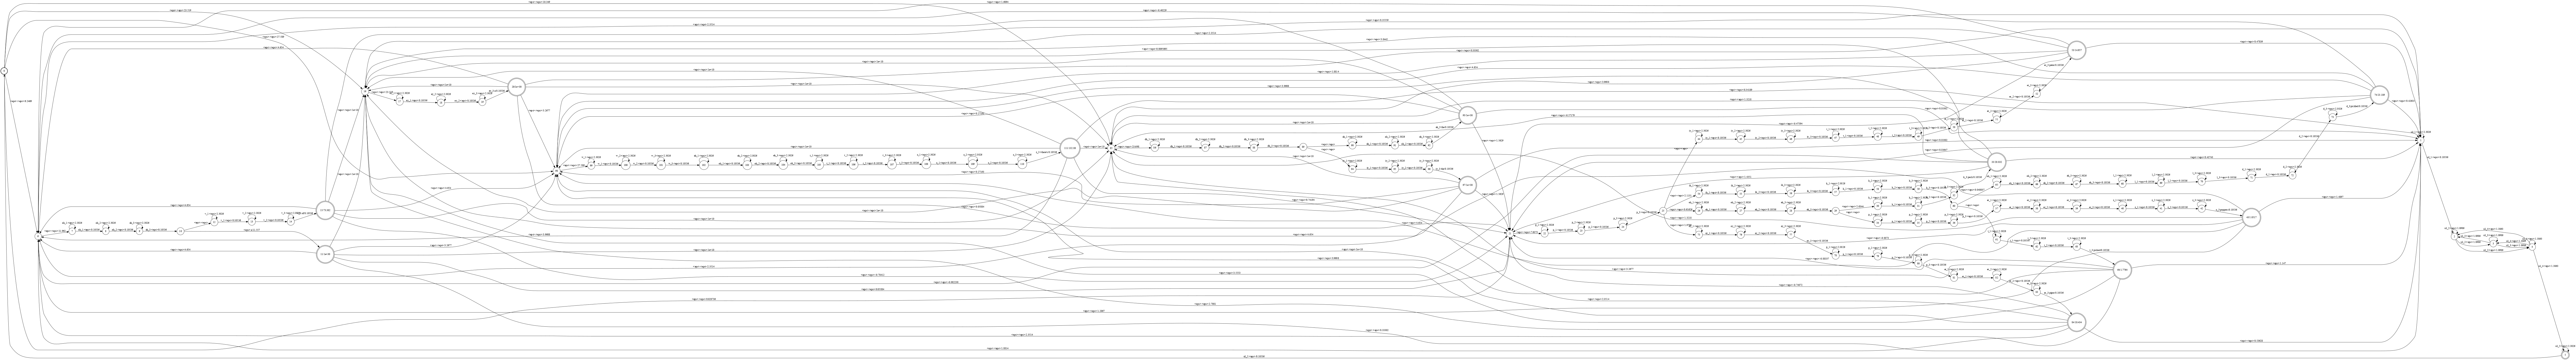

In [22]:
f = create_wfst()
draw_f(f)